# Evaluating solvers for the DISPERSIVE ART GALLERY PROBLEM

In [32]:
from algbench import read_as_pandas
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = '#EAEDEF'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 10

ROUNDING = 40

# Read Data from Benchmark

In [33]:
df = read_as_pandas(
    "./disp_agp_benchmark",
    lambda result: {
        "instance": result["parameters"]["args"]["instance_name"],
        "size": result["parameters"]["args"]["size"],
        "backend": result["parameters"]["args"]["alg_params"]["backend"],
        "obj": result["result"]["dispersion_distance"],
        "runtime": result["runtime"],
        },
    )

df_sat = read_as_pandas("./disp_agp_benchmark_sat",
                       lambda result: {
            "instance": result["parameters"]["args"]["instance_name"],
            "size": result["parameters"]["args"]["size"],
            "backend": result["parameters"]["args"]["alg_params"]["backend"] + "[Glucose4]",
            "runtime": result["runtime"],
            "number_sat_probes": result["result"]["number_sat_probes"],
            "number_sat_solves": result["result"]["number_sat_solves"],
            "number_unsat_solves": result["result"]["number_unsat_solves"],
            "time_compute_shadow_witnesses": result["result"]["time_compute_shadow_witnesses"],
            "time_compute_witnesses": result["result"]["time_compute_witnesses"], # time for shadow witness + time for vispolys
            "time_compute_vispolys": result["result"]["time_compute_vispolys"],
            "time_unsat_solves": result["result"]["time_unsat_solves"],
            "time_sat_solves": result["result"]["time_sat_solves"],
            "time_compute_distances_from_graph": result["result"]["time_compute_distances_from_graph"],
            "time_build_distance_graph": result["result"]["time_build_distance_graph"],
            "total_model_build_time": result["result"]["total_model_build_time"],
    },)

# Enriching Data

In [34]:
def add_type(df):
    conditions = [
        df['instance'].str.startswith('simple'),
        df['instance'].str.startswith('general'),
        df['instance'].str.startswith('srpg_iso_aligned_mc'),
        df['instance'].str.startswith('srpg_iso_aligned'),
        df['instance'].str.startswith('srpg_iso_mc')
    ]
    choices = ['scot_simple','scot_general','srpg_iso_aligned_mc','srpg_iso_aligned','srpg_iso_mc']
    choices_2 = ['scots_hole_free', 'scots', 'orthogonal', 'orthogonal_hole_free', 'orthogonal']
    choices_3 = ['scots', 'scots', 'orthogonal', 'orthogonal', 'orthogonal']
    df['type'] = np.select(conditions, choices, default='srpg_iso')
    df['type_class'] = np.select(conditions, choices_2, default='orthogonal_hole_free')
    df['general_class'] = np.select(conditions, choices_3, default='orthogonal')
    return df

df = add_type(df)
df_sat = add_type(df_sat)

df["backend"] = df["backend"].replace("MIP", "MIP[Gurobi]")
df_sat["backend"] = df_sat["backend"].replace("MIP", "MIP[Gurobi]")

In [35]:
df

,instance,size,backend,obj,runtime,type,type_class,general_class
0,srpg_iso_aligned0000035,36,CP-SAT,7000.000000,0.040223,srpg_iso_aligned,orthogonal_hole_free,orthogonal
1,srpg_iso_aligned0000035,36,SAT[Cadical103],7000.000000,0.009287,srpg_iso_aligned,orthogonal_hole_free,orthogonal
2,srpg_iso_aligned0000035,36,SAT[Cadical153],7000.000000,0.009014,srpg_iso_aligned,orthogonal_hole_free,orthogonal
3,srpg_iso_aligned0000035,36,SAT[Gluecard3],7000.000000,0.008745,srpg_iso_aligned,orthogonal_hole_free,orthogonal
4,srpg_iso0000017,18,CP-SAT,6411.000000,0.021570,srpg_iso,orthogonal_hole_free,orthogonal
...,...,...,...,...,...,...,...,...
33439,general_640_17,640,MIP[Gurobi],10000.000001,20.507051,scot_general,scots,scots
33440,general_640_8,640,MIP[Gurobi],23000.000000,10.103716,scot_general,scots,scots
33441,general_640_3,640,MIP[Gurobi],19000.000000,6.749513,scot_general,scots,scots
33442,general_640_4,640,MIP[Gurobi],13000.000000,8.614754,scot_general,scots,scots


# General Plotting Function

In [36]:
def plot_runtime(df, 
                 backends, # 'CP-SAT', 'MIP[Gurobi]', 'SAT[..]' 
                 instance_types, # 'scot_simple','scot_general','srpg_iso_aligned_mc','srpg_iso_aligned','srpg_iso_mc'
                 save_path=None,
                 ax=None, 
                 figsize=(4.5, 0.9 * 4.5),
                 max_instance_size=1600, 
                 round_precision=ROUNDING, 
                 hue="backend", 
                 hue_order=None,
                 title="", 
                 style=None, 
                 legend=True):
    
    # filter data set
    df = df[(df["backend"].isin(backends)) & (df["type"].isin(instance_types)) & (df["size"] <= max_instance_size)]
    df["size_rounded"] = df["size"].apply(lambda x: (round_precision * round(x / round_precision)))
    
    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.gca()

    sns.lineplot(
        data=df,
        x="size_rounded",
        y="runtime",
        hue=hue,
        errorbar=None,
        hue_order=hue_order,
        style=style,
        ax=ax
    )
    ax.set_xlabel('average size', fontsize=10, color='black')
    ax.set_ylabel('runtime (s)', fontsize=10, color='black')
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    ax.set_title(title, fontsize=10)
    if not legend:
        ax.legend().set_visible(False)
    else:
        ax.legend(title=None, fontsize=7)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

# Compare SAT[Glucose4], CP-SAT, and MIP on random orthogonal polygons

/var/folders/fq/7rwf71g9111bgdw5xfz05kj40000gn/T/ipykernel_15801/2707112253.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["size_rounded"] = df["size"].apply(lambda x: (round_precision * round(x / round_precision)))


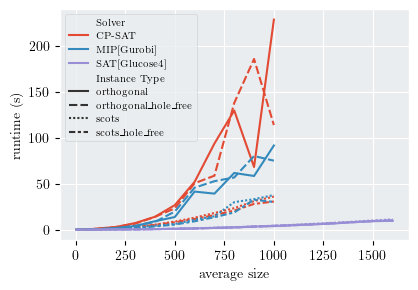

In [37]:
df["Instance Type"] = df["type_class"]
df["Solver"] = df["backend"]
plot_runtime(df.sort_values("Instance Type"), 
            instance_types=["srpg_iso_aligned_mc", "srpg_iso_aligned","srpg_iso_mc", "srpg_iso", "scot_simple", "scot_general"], 
            backends=["CP-SAT", "MIP[Gurobi]", "SAT[Glucose4]"], 
            max_instance_size=1600, 
            round_precision=100, 
            hue_order=["CP-SAT", "MIP[Gurobi]", "SAT[Glucose4]"],
            save_path="./plots/compare_cpsat_sat_mip.pdf",
            figsize=(4.5, 3),
            style="Instance Type",
            hue="Solver"
            )

# Compare SAT[Glucose4], CP-SAT, and MIP on random SCOTs

/var/folders/fq/7rwf71g9111bgdw5xfz05kj40000gn/T/ipykernel_15801/2707112253.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["size_rounded"] = df["size"].apply(lambda x: (round_precision * round(x / round_precision)))


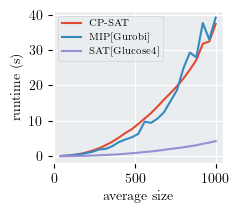

In [38]:
plot_runtime(df, 
            instance_types=["scot_simple", "scot_general"], 
            backends=["CP-SAT", "MIP[Gurobi]", "SAT[Glucose4]"], 
            max_instance_size=1000, 
            round_precision=ROUNDING, 
            hue_order=["CP-SAT", "MIP[Gurobi]", "SAT[Glucose4]"],
            save_path="./plots/compare_scots_cpsat_sat_mip.pdf",
            figsize=(2.2, 0.9 * 2.2)
            )

# Compare different SAT solvers on random orthogonal polygons

/var/folders/fq/7rwf71g9111bgdw5xfz05kj40000gn/T/ipykernel_15801/2707112253.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["size_rounded"] = df["size"].apply(lambda x: (round_precision * round(x / round_precision)))


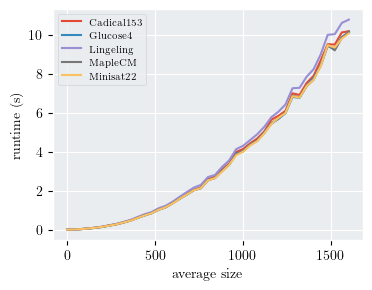

In [39]:
df2 = df.copy()
df2["backend"] = df2["backend"].replace({
    "SAT[Cadical153]": "Cadical153", 
    "SAT[Glucose4]": "Glucose4", 
    "SAT[Lingeling]": "Lingeling", 
    "SAT[MapleCM]": "MapleCM", 
    "SAT[Minisat22]": "Minisat22"
})

plot_runtime(df2, 
            instance_types=["srpg_iso_aligned_mc", "srpg_iso_aligned","srpg_iso_mc", "srpg_iso"], 
            backends=["Cadical153", "Glucose4", "Lingeling", "MapleCM", "Minisat22"], 
            max_instance_size=1600, 
            round_precision=ROUNDING, 
            hue_order=["Cadical153", "Glucose4", "Lingeling", "MapleCM", "Minisat22"],
            save_path="./plots/compare_different_sat.pdf",
            figsize=(4,  3)
            )

# Different Solvers for different Polygon Classes

/var/folders/fq/7rwf71g9111bgdw5xfz05kj40000gn/T/ipykernel_15801/2707112253.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["size_rounded"] = df["size"].apply(lambda x: (round_precision * round(x / round_precision)))
/var/folders/fq/7rwf71g9111bgdw5xfz05kj40000gn/T/ipykernel_15801/2707112253.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["size_rounded"] = df["size"].apply(lambda x: (round_precision * round(x / round_precision)))
/var/folders/fq/7rwf71g9111bgdw5xfz05kj40000gn/T/ipykernel_158

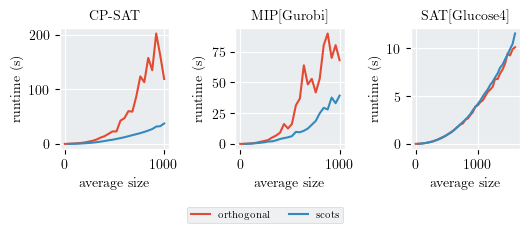

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(3*1.8,3* 0.5 * 1.4), sharey=False)

# Compare CP-SAT performance for SCOTs and orthogonal polygons
plot_runtime(df, 
            ax=axes[0],
            instance_types=["srpg_iso_aligned_mc", "srpg_iso_aligned","srpg_iso_mc", "srpg_iso", "scot_simple", "scot_general"], 
            backends=["CP-SAT"], 
            max_instance_size=1000, 
            round_precision=ROUNDING, 
            hue="general_class", 
            title="CP-SAT", 
            hue_order=["orthogonal", "scots"],
            figsize=(1.4, 0.9 * 1.4),
            legend=False
            )
    
# Compare MIP performance for SCOTs and orthogonal polygons
plot_runtime(df2, 
            ax=axes[1],
            instance_types=["srpg_iso_aligned_mc", "srpg_iso_aligned","srpg_iso_mc", "srpg_iso", "scot_simple", "scot_general"], 
            backends=["MIP[Gurobi]"], 
            max_instance_size=1000, 
            round_precision=ROUNDING, 
            hue="general_class", 
            title="MIP[Gurobi]", 
            hue_order=["orthogonal", "scots"],
            figsize=(1.4, 0.9 * 1.4),
            legend=False
            )
    
# Compare SAT performance for SCOTs and orthogonal polygons
plot_runtime(df, 
            ax=axes[2],
            instance_types=["srpg_iso_aligned_mc", "srpg_iso_aligned","srpg_iso_mc", "srpg_iso", "scot_simple", "scot_general"], 
            backends=["SAT[Glucose4]"], 
            max_instance_size=1600, 
            round_precision=ROUNDING, 
            hue="general_class", 
            title="SAT[Glucose4]", 
            hue_order=["orthogonal", "scots"],
            figsize=(1.4, 0.9 * 1.4),
            legend=False
            )

fig.tight_layout()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=len(handles), fontsize=7)
plt.savefig("./plots/all_backends_merged.pdf", bbox_inches='tight')

/var/folders/fq/7rwf71g9111bgdw5xfz05kj40000gn/T/ipykernel_15801/2707112253.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["size_rounded"] = df["size"].apply(lambda x: (round_precision * round(x / round_precision)))
/var/folders/fq/7rwf71g9111bgdw5xfz05kj40000gn/T/ipykernel_15801/2707112253.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["size_rounded"] = df["size"].apply(lambda x: (round_precision * round(x / round_precision)))
/var/folders/fq/7rwf71g9111bgdw5xfz05kj40000gn/T/ipykernel_158

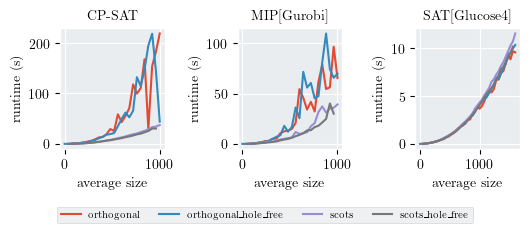

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(3*1.8,3* 0.5 * 1.4), sharey=False)

# Compare SAT[Glucose4] performance for SCOTs and general orthogonal polygons (with and without holes, respectively)
plot_runtime(df,
            ax=axes[2], 
            instance_types=["srpg_iso_aligned_mc", "srpg_iso_aligned","srpg_iso_mc", "srpg_iso", "scot_simple", "scot_general"], 
            backends=["SAT[Glucose4]"], 
            max_instance_size=1600, 
            round_precision=ROUNDING, 
            hue="type_class", 
            title="SAT[Glucose4]", 
            hue_order=["orthogonal", "orthogonal_hole_free", "scots", "scots_hole_free"],
            figsize=(1.4, 0.9 * 1.4),
            legend=False
            )

# Compare CP-SAT performance for SCOTs and general orthogonal polygons (with and without holes, respectively)
plot_runtime(df, 
            ax=axes[0],  
            instance_types=["srpg_iso_aligned_mc", "srpg_iso_aligned","srpg_iso_mc", "srpg_iso", "scot_simple", "scot_general"], 
            backends=["CP-SAT"], 
            max_instance_size=1000, 
            round_precision=ROUNDING, 
            hue="type_class", 
            title="CP-SAT", 
            hue_order=["orthogonal", "orthogonal_hole_free", "scots", "scots_hole_free"],
            figsize=(1.4, 0.9 * 1.4),
            legend=False
            )

# Compare MIP performance for SCOTs and general orthogonal polygons (with and without holes, respectively)
plot_runtime(df2, 
            ax=axes[1],  
            instance_types=["srpg_iso_aligned_mc", "srpg_iso_aligned","srpg_iso_mc", "srpg_iso", "scot_simple", "scot_general"], 
            backends=["MIP[Gurobi]"], 
            max_instance_size=1000, 
            round_precision=ROUNDING, 
            hue="type_class", 
            title="MIP[Gurobi]", 
            hue_order=["orthogonal", "orthogonal_hole_free", "scots", "scots_hole_free"],
            figsize=(1.4, 0.9 * 1.4),
            legend=False
            )

fig.tight_layout()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=len(handles), fontsize=7)
plt.savefig("./plots/all_backends.pdf", bbox_inches='tight')

# Compute Runtime Statistics during SAT Solve

In [42]:
def compute_avg_phase_lengths(df, min_size=0, max_size=1600):
    df = df[(df['size'] >= min_size) & (df['size'] <= max_size)]
    avg_solve_sat = df["time_sat_solves"].mean()
    avg_solve_unsat = df["time_unsat_solves"].mean()
    avg_solve = avg_solve_sat + avg_solve_unsat
    avg_witnesses = df["time_compute_witnesses"].mean()
    avg_remainder = df["runtime"].mean() - avg_solve - avg_witnesses
    return avg_solve, avg_solve_sat, avg_solve_unsat, avg_witnesses, avg_remainder

s_avg_solve, s_avg_solve_sat, s_avg_solve_unsat, s_avg_witnesses, s_avg_remainder = compute_avg_phase_lengths(df_sat, min_size=1, max_size=800)
l_avg_solve, l_avg_solve_sat, l_avg_solve_unsat, l_avg_witnesses, l_avg_remainder = compute_avg_phase_lengths(df_sat, min_size=801, max_size=1600)

In [43]:
l_avg_solve, l_avg_solve_sat, l_avg_solve_unsat, l_avg_witnesses, l_avg_remainder

(0.0069343831607652446,
 0.0008570584464227855,
 0.006077324714342459,
 2.6364250366504374,
 3.6525743966637325)

In [44]:
t = df_sat[df_sat["size"]>=1500]
t.describe()

,size,runtime,number_sat_probes,number_sat_solves,number_unsat_solves,time_compute_shadow_witnesses,time_compute_witnesses,time_compute_vispolys,time_unsat_solves,time_sat_solves,time_compute_distances_from_graph,time_build_distance_graph,total_model_build_time
count,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000
mean,1576.000000,10.516238,14.656085,3.111111,11.544974,0.335372,4.380344,4.044973,0.008925,0.001216,0.517038,0.784241,3.419894
std,46.820617,1.045595,2.860819,1.377375,2.402202,0.208389,0.420722,0.300723,0.001118,0.000805,0.046398,0.073599,0.590340
min,1500.000000,7.632078,8.000000,1.000000,6.000000,0.162426,3.624151,3.458831,0.005971,0.000243,0.396835,0.661525,2.073651
25%,1524.000000,9.979589,15.000000,2.000000,11.000000,0.183886,4.094475,3.858687,0.008308,0.000771,0.481758,0.725335,3.142726
50%,1564.000000,10.545898,16.000000,3.000000,12.000000,0.299993,4.318667,4.036356,0.008949,0.000958,0.523482,0.788662,3.458129
75%,1604.000000,11.354132,16.000000,4.000000,13.000000,0.344540,4.652258,4.253440,0.009619,0.001337,0.551294,0.810993,3.671633
max,1696.000000,12.880016,19.000000,7.000000,15.000000,1.315365,6.080416,4.765051,0.012786,0.004631,0.615725,0.988429,5.297310


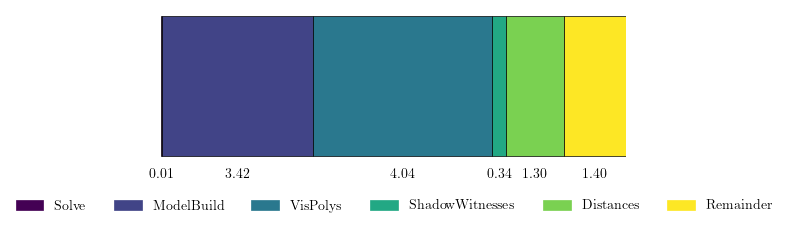

In [ ]:
def plot_stacked_bar(runtimes, labels=None, colors=None):
    if colors is None:
        colors = plt.cm.viridis(np.linspace(0, 1, len(runtimes)))

    fig, ax = plt.subplots(figsize=(6, 2))
    left_positions = np.cumsum([0] + runtimes[:-1])
    ax.barh(0, runtimes, left=left_positions, color=colors, edgecolor='black')

    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim(0, sum(runtimes))
    ax.set_frame_on(False)

    if labels:
        handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i]) for i in range(len(labels))]
        ax.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=len(labels), frameon=False)

    for i, runtime in enumerate(runtimes):
        x_pos = left_positions[i] + runtime / 2
        ax.text(x_pos, -0.5, f'{runtime:.2f}', ha='center', va='center', fontsize=10, color='black')

    plt.show()


In [ ]:
solve = t["time_sat_solves"].mean() + t["time_unsat_solves"].mean()
model_build = t["total_model_build_time"].mean()
vis_polys = t["time_compute_vispolys"].mean()
shadow_witnesses = t["time_compute_shadow_witnesses"].mean()
distances = t["time_compute_distances_from_graph"].mean() + t["time_build_distance_graph"].mean()
remainder = t["runtime"].mean() - solve - model_build - vis_polys - shadow_witnesses - distances
runtimes = [solve, model_build, vis_polys, shadow_witnesses, distances, remainder]
labels = ["Solve", "ModelBuild", "VisPolys", "ShadowWitnesses", "Distances", "Remainder"]
plot_stacked_bar(runtimes, labels)

# Impact of computing Witnesses for the Runtime

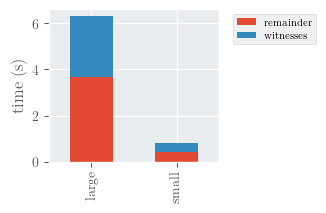

In [46]:
import pandas as pd
df = pd.DataFrame({
    "Size": ["small", "small", "large", "large"],
    "Phase": ["witnesses", "remainder"] * 2,
    "Runtime": [s_avg_witnesses, s_avg_remainder + s_avg_solve, l_avg_witnesses, l_avg_remainder + l_avg_solve]
})

df_pivot = df.pivot(index="Size", columns="Phase", values="Runtime")
df_pivot.plot(kind="bar", stacked=True, figsize=(2.2, 0.9 * 2.2))

plt.xlabel("")
plt.ylabel("time (s)")
plt.legend(title="", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=7)
plt.show()

In [47]:
df

,Size,Phase,Runtime
0,small,witnesses,0.392400
1,small,remainder,0.422884
2,large,witnesses,2.636425
3,large,remainder,3.659509


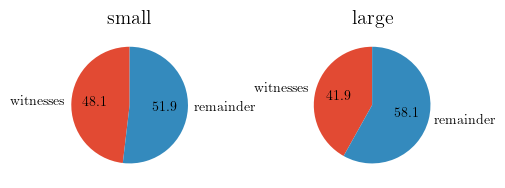

In [48]:
sizes = ['small', 'large']
witnesses = [s_avg_witnesses,l_avg_witnesses]
remainder = [s_avg_remainder + s_avg_solve, l_avg_remainder + l_avg_solve]

fig, axs = plt.subplots(1, 2, figsize=(5, 0.9 * 2.2))

for i, size in enumerate(sizes):
    ax = axs[i]
    ax.pie([witnesses[i], remainder[i]], labels=['witnesses', 'remainder'], autopct='%1.1f%%', startangle=90)
    ax.set_title(size)

plt.tight_layout()
plt.show()

# Ratio between SAT and UNSAT solves

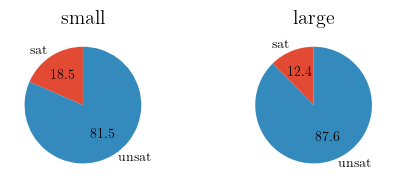

In [49]:
sat = [s_avg_solve_sat,l_avg_solve_sat]
unsat = [s_avg_solve_unsat,l_avg_solve_unsat]

fig, axs = plt.subplots(1, 2, figsize=(5, 0.9 * 2.2))

for i, size in enumerate(sizes):
    ax = axs[i]
    ax.pie([sat[i], unsat[i]], labels=['sat', 'unsat'], autopct='%1.1f%%', startangle=90)
    ax.set_title(size)

plt.tight_layout()
plt.show()